# 2.1. KOH1: Podstawowa sieć Kohonena (2 tygodnie, 2 punkty)
### Zaimplementować sieć Kohonena złożoną z neuronów w prostokątnej siatce M×N (M,N są parametrami programu), która działa dla zbioru wektorów (wszystkich o tej samej długości).

### Zaimplementować następujące funkcje sąsiedztwa:

- funkcję gaussowską
- minus druga pochodną funkcji gaussowskiej.
#### W obu implementacjach dodać możliwość zmiany szerokości sąsiedztwa z użyciem parametru (technicznie oznacza to przemnożenie argumentu x przez stałą) i sprawdzić dla kilku wartości z przedziału [0.1,1]

Jako funkcji wygaszającą uczenie wraz z kolejnymi iteracjami użyć funkcji α(t)=e−t/λ  
Przetestować działanie sieci na dostarczonych prostych zbiorach danych:

- danych 2d skupionych w wierzchołkach sześciokąta,  
- danych 3d skupionych w wierzchołkach sześcianu.  
Dane, odpowiednio hexagon i cube, mają 3/4 kolumny. Do sieci podać tylko kolumny x, y i z (w przypadku sześciokąta bez z). Ostatnia kolumna, c, zawiera identyfikator wierzchołka bryły/figury.  
- Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych? 
- Czy znalezione klastry pokrywają się z identyfikatorami wierzchołków?  

Miary, które posłużyły do porównania parametru szerokości sąsiedztwa:  
- najmniejsza odległość między klastrami  
- średnia odległość wewnątrz klastrów  
- średni dystans do środka klastra  
- silhouette score  
- homogeneity, completeness
- adjusted rand score

https://towardsdatascience.com/7-evaluation-measures-for-clustering-algorithms-bdc537ff54d2#0968:  
https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness  
https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from scipy.spatial import distance
import math
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, adjusted_rand_score

In [110]:
class Kohonen:
    def __init__(self, N, M, dataset, width):
        self.M=M
        self.N=N
        self.neurons = np.random.uniform(np.min(dataset), np.max(dataset), size=(N*M,dataset.shape[1]))
        self.width = width
        self.dataset = dataset

    def learn(self, lambda_, method = 'gauss'):
        if method == 'mexican':
            neigh_fun = self.mexican_hat
        else:
            neigh_fun = self.gauss

        for iteration in range(lambda_):
            p = np.random.permutation(len(self.dataset))
            x = self.dataset[p]

            for input in x:
                bmu_idx = np.argmin(np.linalg.norm(self.neurons - input, axis=1)) #Best Matching Unit
                for i, neuron in enumerate(self.neurons):
               # calculate the distance between the neuron and the BMU
                    dist = self.dist(bmu_idx, i)

                    # calculate the learning rate for the neuron
                    lr = neigh_fun(dist, iteration) * self.alpha_fun(iteration, lambda_)

                    # update the weights of the neuron
                    # if np.any(abs(self.neurons[i] + lr * (input - neuron)) > self.range):
                    #     continue
                    self.neurons[i] += lr * (input - neuron)

    def classify(self):
        return [np.argmin([np.linalg.norm(neuron-input) for neuron in self.neurons]) for input in self.dataset]
    
    def limit_neurons(self, n):
        while(len(self.neurons) > n):
            x = [0] * len(self.neurons)
            tmp = [np.argmin([np.linalg.norm(neuron-input) for neuron in self.neurons]) for input in self.dataset]
            for t in tmp:
                x[t]+=1
            self.neurons = np.delete(self.neurons, np.argmin(x), 0)
    @staticmethod
    def gauss(x,t):
        return math.exp(-1 * x**2 * t**2)        
    
    @staticmethod
    def mexican_hat(x, t):
        value = (1-x**2) * math.exp(-1 * x**2 * t**2 / 2)
        return value

    def dist(self, x, y):
        a = x%self.N-y%self.N #it is the horizontal distance between the two neurons.
        b = math.floor(x/self.N)-math.floor(y/self.N) #vertical distance between the neurons.
        
        return self.width*math.sqrt(a**2 + b**2) #pythagorean with width as the neighbourhood width
    
    def alpha_fun(self, iteration, lambda_):
        return math.exp(-iteration/lambda_)
    

In [37]:
def min_dist_between_clusters(X, labels):
    min_dist = np.inf
    for cluster_i in set(labels):
        cluster_i_idx = np.where(labels == cluster_i)
        for cluster_j in set(labels):
            if cluster_i == cluster_j:
                continue
            else:
                cluster_j_idx = np.where(labels == cluster_j)
                intercluster_distance = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                min_dist = min(min_dist, intercluster_distance)
    return(min_dist)

def mean_dist_in_clusters(X, labels):
    distances = []
    for cluster in set(labels):
        cluster_idx = np.where(labels == cluster)
        distances.append(np.mean(distance.pdist(X[cluster_idx])))
    return(np.mean(distances))

def mean_dist_to_center(X, labels):
    distances = []
    for cluster in set(labels):
        cluster_idx = np.where(labels == cluster)
        cluster_mean = np.mean(X[cluster_idx], axis=0, keepdims=True)
        mean_distance = np.mean(distance.cdist(X[cluster_idx], cluster_mean))
        distances.append(mean_distance)
    return(np.mean(distances))

In [26]:
def count_clustering_scores(dataset,model, cluster_num, score_fun, method = 'gauss', iterations = 100):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    model.learn(lambda_=iterations, method=method)
    neurons =  model.neurons
    for k in cluster_num_iter:
        model.neurons = neurons
        model.limit_neurons(k)
        c = model.classify()
        eval = score_fun(dataset, c)
        scores.append(eval)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

## dataset 1 - hexagon

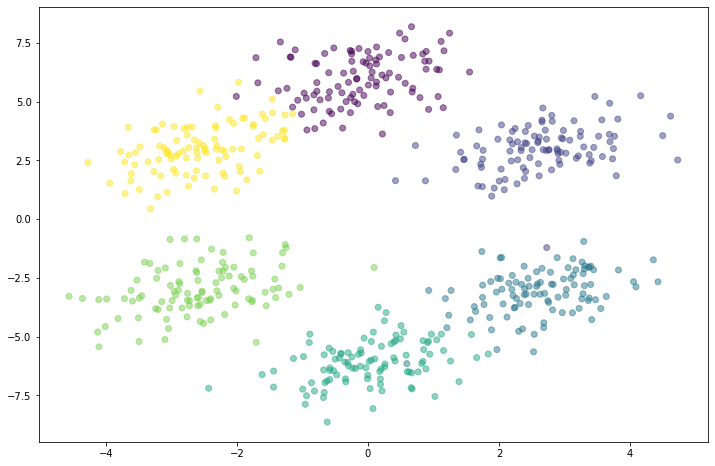

In [105]:
dataset = pd.read_csv('../dane_kohonen/hexagon.csv')
plt.figure(figsize = (12, 8))
plt.scatter(dataset['x'], dataset['y'], c=dataset['c'], alpha=0.5)

labels = dataset['c']
dataset=(dataset-dataset.mean())/dataset.std()
x = np.asarray(dataset.drop(columns = ['c']))

### gaussowska funkcja sąsiedztwa

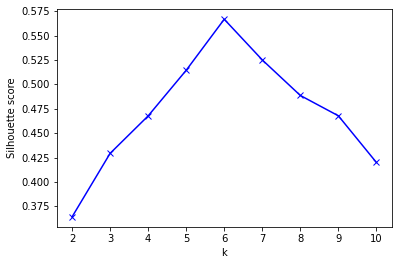

In [28]:
model = Kohonen(4,4,x,1)

cluster_num_seq = range(2, 11) 
silhouette_vec = count_clustering_scores(x,model, cluster_num_seq, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

silhouette score potwierdza, że pierwotny podział na 6 klastrów jest właściwy

In [30]:
measures = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
           }


models = {}
for width in np.linspace(1/10, 1, 10):
    width = np.round(width, 1)
    models[f'width = {width}'] = Kohonen(4,4,x,width)


df = pd.DataFrame()
for model_key in models:
    for measure_key in measures:
        df.loc[model_key, measure_key] = count_clustering_scores(X=x, cluster_num=6,
                                                                model=models[model_key],
                                                                score_fun=measures[measure_key])

min dist between clusters  mean dist in clust  \
width = 0.1                   0.058286            0.497787   
width = 0.2                   0.002472            0.505322   
width = 0.3                   0.054569            0.500681   
width = 0.4                   0.061641            0.499491   
width = 0.5                   0.050564            0.496932   
width = 0.6                   0.051858            0.496385   
width = 0.7                   0.039725            0.496411   
width = 0.8                   0.061560            0.496018   
width = 0.9                   0.013313            0.496499   
width = 1.0                   0.034800            0.500174   

             mean dist to clust center  silhouette  
width = 0.1                   0.348049    0.576424  
width = 0.2                   0.352191    0.574786  
width = 0.3                   0.349012    0.576851  
width = 0.4                   0.348266    0.574145  
width = 0.5                   0.347479    0.572681  
width = 0.6                   0.354878    0.569683  
width = 0.7                   0.347397    0.574697  
width = 0.8                   0.350769    0.572228  
width = 0.9                   0.348670    0.575371  
width = 1.0                   0.348746    0.569578

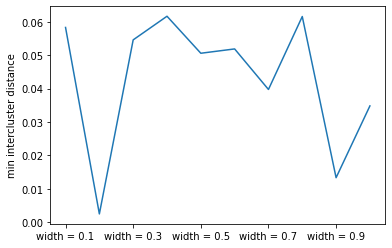

In [31]:
df['min dist between clusters'].plot(ylabel = "min intercluster distance")
df

- statystyka minimalnej odległości między klastrami dość różnorodna,
- pozostałe statystyki bardzo podobnie dla każdej szerokości sąsiedztwa.

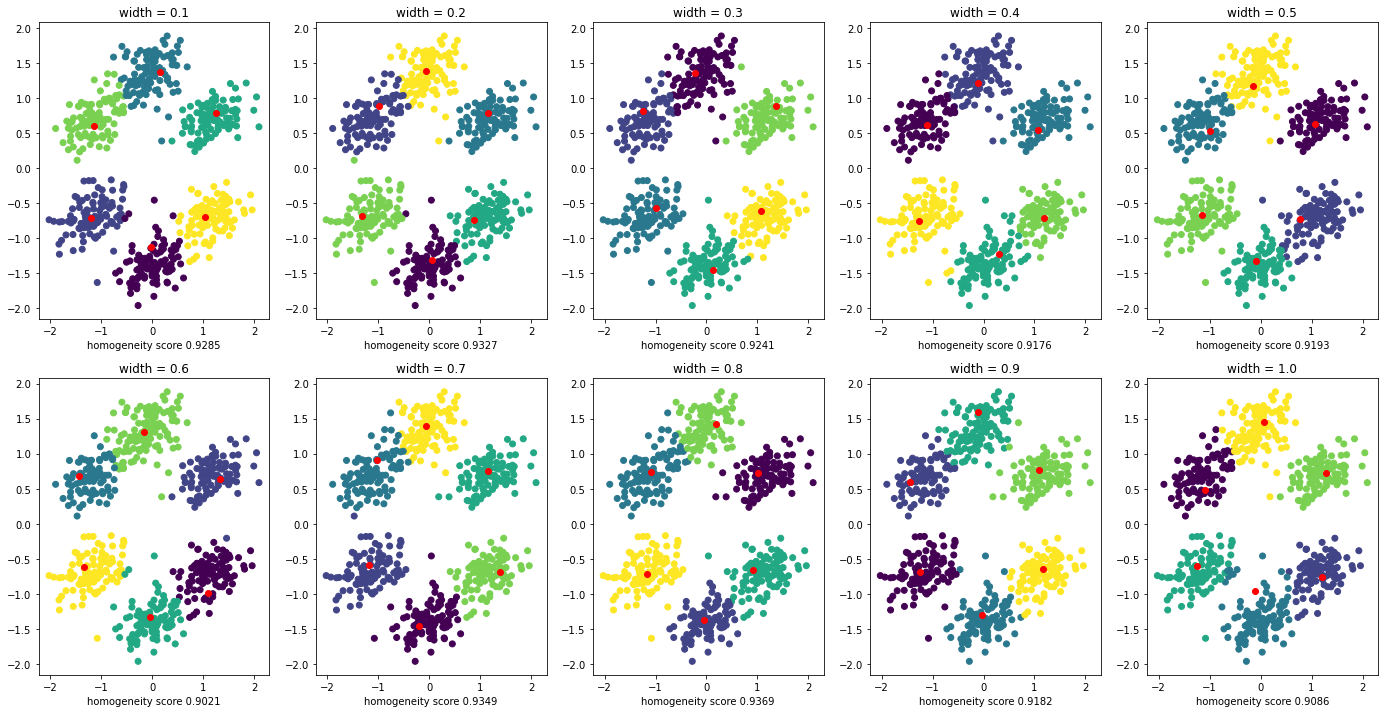

In [32]:
fig = plt.figure(figsize=(24,12))
for i, key in enumerate(models):
    model = models[key]
    c = model.classify()
    plt.subplot(2, 5, i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c)
    plt.scatter(model.neurons[:,0],model.neurons[:,1], color = "red")
    plt.xlabel(f"homogeneity score {np.round(measures.homogeneity_score(labels, c),4)}")
    plt.title(key)

##### A jak z zadaniem radzą sobie różne rozmiary map?:

In [101]:
measures_1 = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
           }
measures_2 = {
    'completeness' : completeness_score,
    'homogeneity' : homogeneity_score,
    'adjusted rand score' : adjusted_rand_score,
}
models = {}
    
sizes = np.linspace(3, 13, 6)
sizes = [int(size) for size in sizes]
df = pd.DataFrame()

for size in sizes:
    model = Kohonen(size, size, x, 0.5)
    model.learn(100, 'gauss')
    model.limit_neurons(6)
    models[f'{size}x{size}'] = model
    c = model.classify()
    for measure_key in measures_1:
        fun = measures_1[measure_key]
        score = fun(x, c)
        df.loc[f'{size}x{size}', measure_key] = score

    for measure_key in measures_2:
        fun = measures_2[measure_key]
        score = fun(labels, c)
        df.loc[f'{size}x{size}', measure_key] = score
df

min dist between clusters  mean dist in clust  \
3x3                     0.054720            0.505025   
5x5                     0.057268            0.497609   
7x7                     0.068368            0.494455   
9x9                     0.051858            0.494530   
11x11                   0.051555            0.496524   
13x13                   0.051555            0.495921   

       mean dist to clust center  silhouette  completeness  homogeneity  \
3x3                     0.354454    0.562966      0.906045     0.905167   
5x5                     0.348768    0.575178      0.935666     0.935485   
7x7                     0.346921    0.579737      0.940113     0.939983   
9x9                     0.347108    0.574919      0.915012     0.913642   
11x11                   0.348239    0.577068      0.949216     0.949102   
13x13                   0.347842    0.577413      0.944043     0.943912   

       adjusted rand score  
3x3               0.901091  
5x5               0.941186  
7x7               0.948561  
9x9               0.911211  
11x11             0.956424  
13x13             0.952553

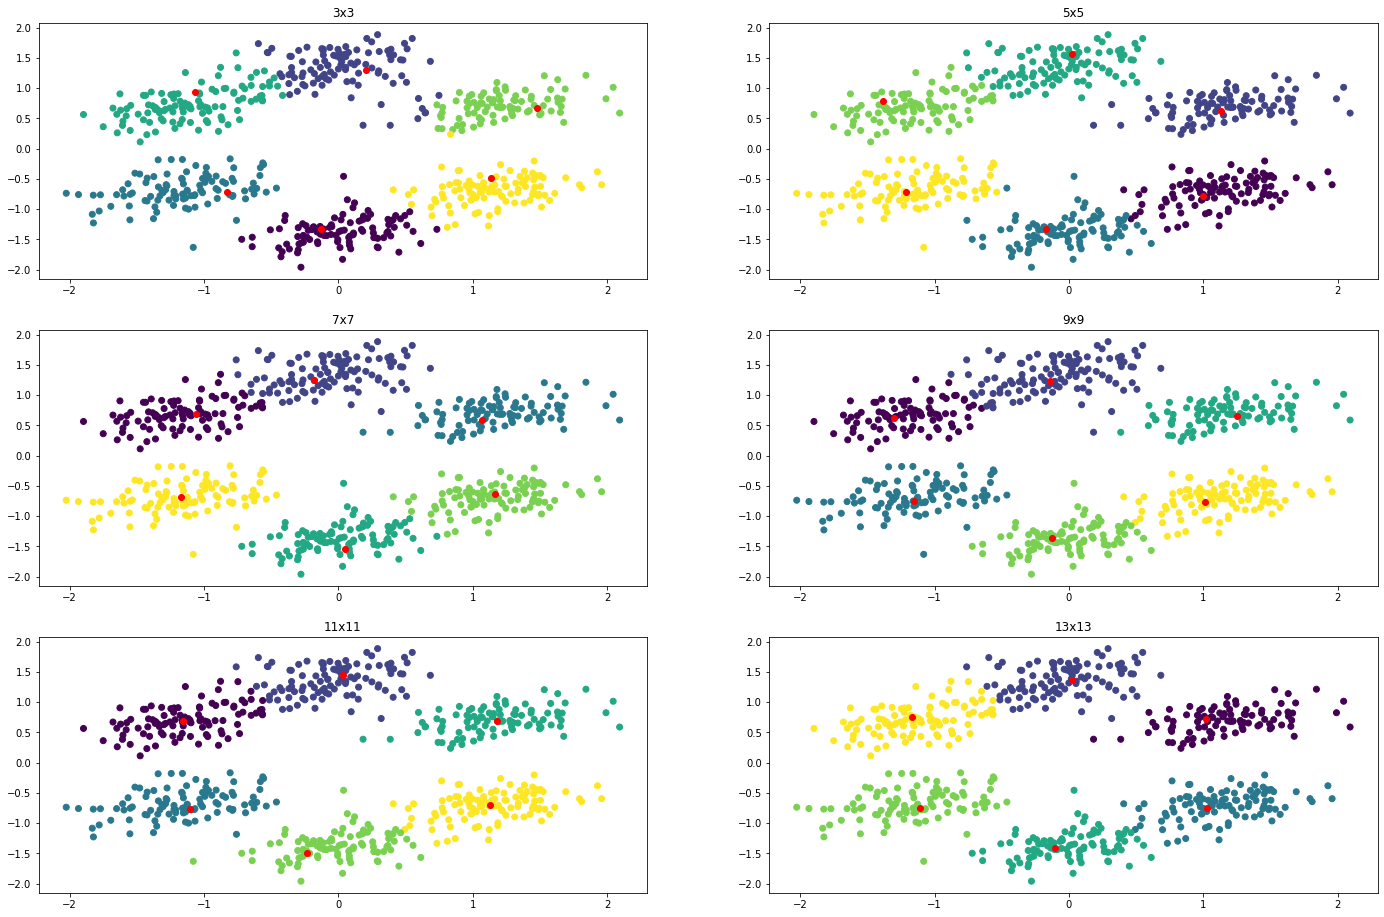

In [102]:
plt.figure(figsize=(24,16))
i = 0
for model_key in models:
    i+=1
    model =  models[model_key]
    c = model.classify()
    plt.subplot(3,2,i)
    plt.scatter(x[:,0], x[:,1], c = c)
    plt.scatter(model.neurons[:,0], model.neurons[:,1], c = 'red')
    plt.title(model_key)

### kapelusz meksykański - funkcja sąsiedztwa

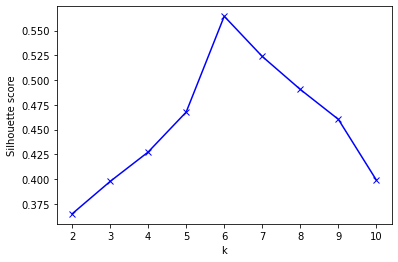

In [112]:
model = Kohonen(4,4,x, 0.1)

cluster_num_seq = range(2, 11) 
silhouette_vec = count_clustering_scores(x,model, cluster_num_seq, silhouette_score, method = 'mexican', iterations=100)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

tak samo jak poprzednio, optymalny podział to 6 klastrów

In [177]:
measures = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }


models = {}
for width in np.linspace(1/10, 1, 10):
    width = np.round(width, 1)
    models[f'width = {width}'] = Kohonen(4,4,x,width)


df = pd.DataFrame()
for model_key in models:
    for measure_key in measures:
        df.loc[model_key, measure_key] = count_clustering_scores(X=x, cluster_num=6,
                                                                model=models[model_key],
                                                                score_fun=measures[measure_key], method = 'mexican', iterations = 100)

min dist between clusters  mean dist in clust  \
width = 0.1                   0.026658            0.495682   
width = 0.2                   0.068736            0.494504   
width = 0.3                   0.039647            0.496220   
width = 0.4                   0.021925            0.495326   
width = 0.5                   0.023613            0.498317   
width = 0.6                   0.031636            0.502386   
width = 0.7                   0.031636            0.494899   
width = 0.8                   0.060559            0.506329   
width = 0.9                   0.047689            0.501165   
width = 1.0                   0.055282            0.495951   

             mean dist to clust center  silhouette  
width = 0.1                   0.349422    0.570291  
width = 0.2                   0.347889    0.568470  
width = 0.3                   0.347442    0.572492  
width = 0.4                   0.347903    0.567826  
width = 0.5                   0.348810    0.573874  
width = 0.6                   0.347805    0.573766  
width = 0.7                   0.364282    0.570288  
width = 0.8                   0.351851    0.568759  
width = 0.9                   0.346793    0.568146  
width = 1.0                   0.350044    0.570307

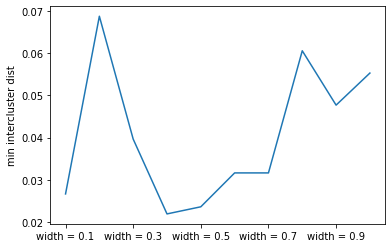

In [178]:
df['min dist between clusters'].plot(ylabel='min intercluster dist')
df

znów minimalna odległość między klastrami jest w zasadzie jedyną statystyką różniącą wyniki dla poszczególnych szerokości sąsiedztwa

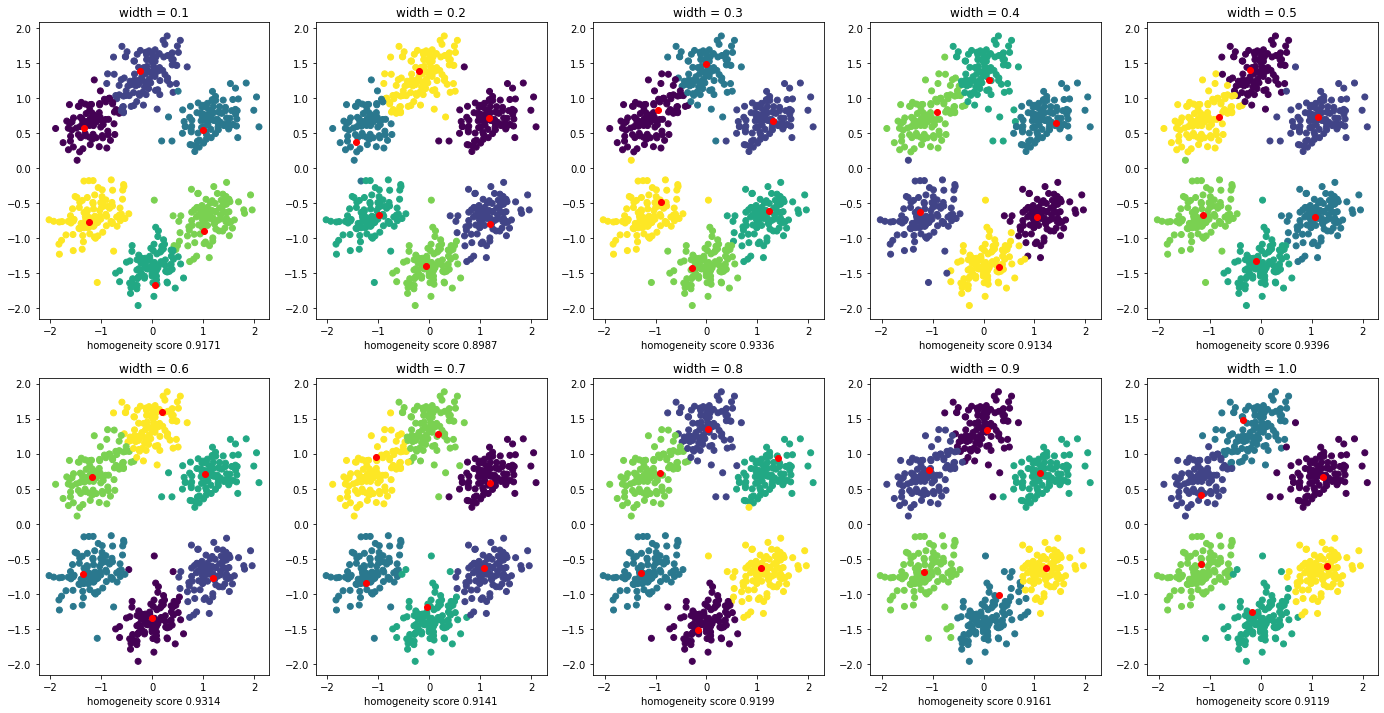

In [ ]:
fig = plt.figure(figsize=(24,12))
for i, key in enumerate(models):
    model = models[key]
    c = model.classify()
    plt.subplot(2, 5, i+1)
    plt.scatter(dataset['x'], dataset['y'], c=c)
    plt.scatter(model.neurons[:,0],model.neurons[:,1], color = "red")
    plt.xlabel(f"homogeneity score {np.round(measures.homogeneity_score(labels, c), 4)}")
    plt.title(key)

In [123]:
measures_1 = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
           }
measures_2 = {
    'completeness' : completeness_score,
    'homogeneity' : homogeneity_score,
    'adjusted rand score' : adjusted_rand_score,
}
models = {}
    
sizes = np.linspace(3, 13, 6)
sizes = [int(size) for size in sizes]
df = pd.DataFrame()

for size in sizes:
    model = Kohonen(size, size, x, 0.1)
    model.learn(100, method='mexican')
    model.limit_neurons(6)
    models[f'{size}x{size}'] = model
    c = model.classify()
    for measure_key in measures_1:
        fun = measures_1[measure_key]
        score = fun(x, c)
        df.loc[f'{size}x{size}', measure_key] = score

    for measure_key in measures_2:
        fun = measures_2[measure_key]
        score = fun(labels, c)
        df.loc[f'{size}x{size}', measure_key] = score
df

min dist between clusters  mean dist in clust  \
3x3                     0.068368            0.497174   
5x5                     0.051555            0.495166   
7x7                     0.048263            0.496420   
9x9                     0.054720            0.499010   
11x11                   0.051555            0.498890   
13x13                   0.014587            0.495057   

       mean dist to clust center  silhouette  completeness  homogeneity  \
3x3                     0.348685    0.576605      0.939046     0.938914   
5x5                     0.347407    0.579057      0.942712     0.942686   
7x7                     0.348055    0.573748      0.909845     0.908982   
9x9                     0.350047    0.572496      0.919604     0.919179   
11x11                   0.349695    0.571682      0.925933     0.925454   
13x13                   0.347279    0.578328      0.931719     0.931443   

       adjusted rand score  
3x3               0.944972  
5x5               0.952465  
7x7               0.910817  
9x9               0.921961  
11x11             0.929948  
13x13             0.936941

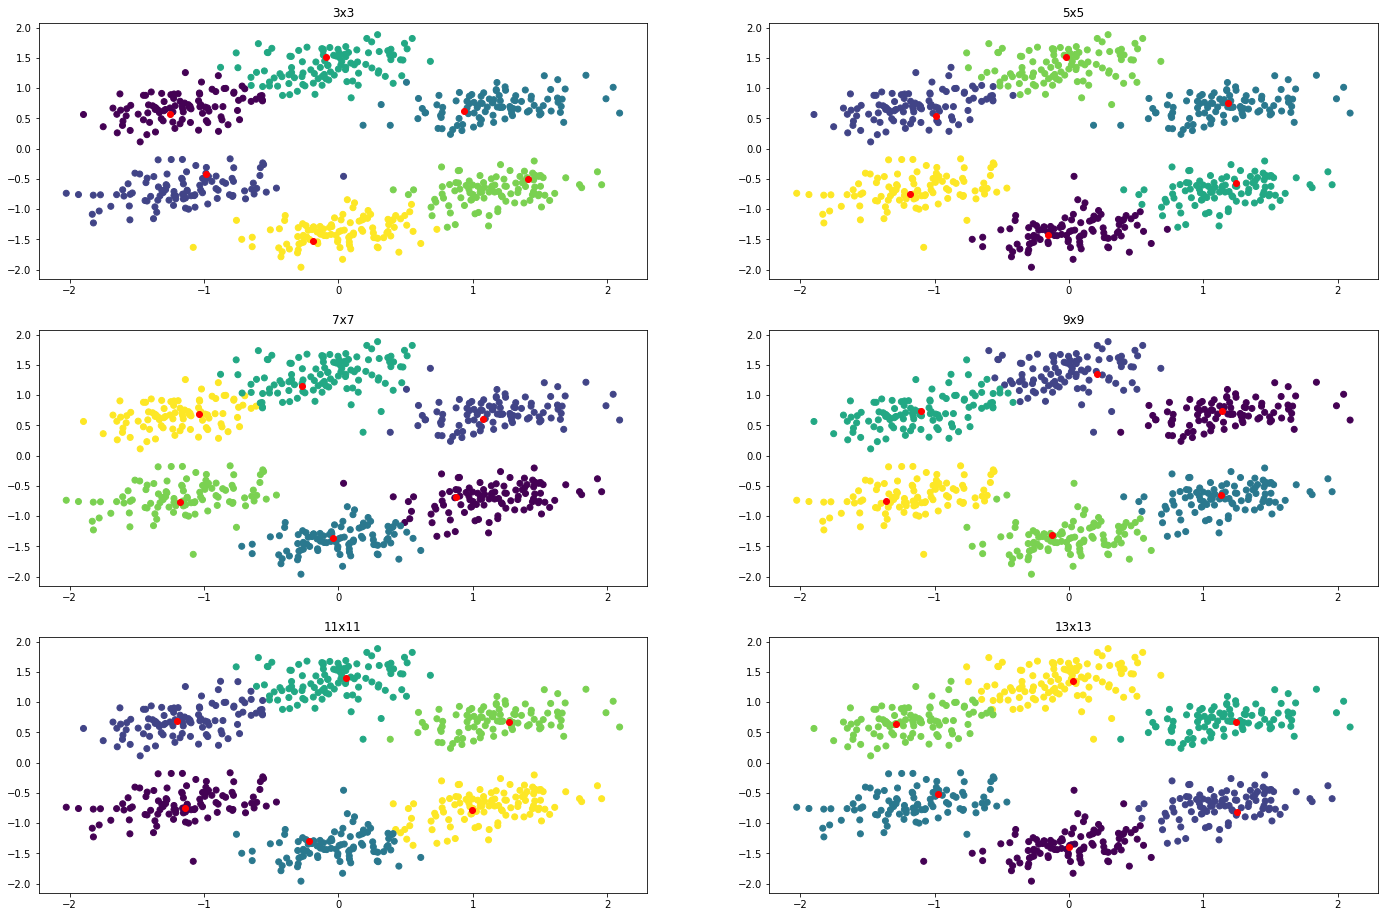

In [124]:
plt.figure(figsize=(24,16))
i = 0
for model_key in models:
    i+=1
    model =  models[model_key]
    c = model.classify()
    plt.subplot(3,2,i)
    plt.scatter(x[:,0], x[:,1], c = c)
    plt.scatter(model.neurons[:,0], model.neurons[:,1], c = 'red')
    plt.title(model_key)

## dataset drugi - cube

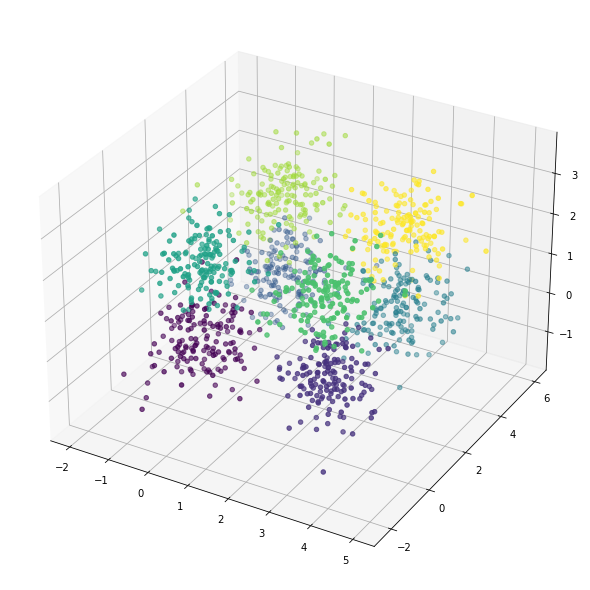

In [125]:
dataset = pd.read_csv('../dane_kohonen/cube.csv')

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=dataset['c'])

labels = dataset['c']
dataset=(dataset-dataset.mean())/dataset.std()
x = np.asarray(dataset.drop(columns = ['c']))

### gaussowska funkcja sąsiedztwa

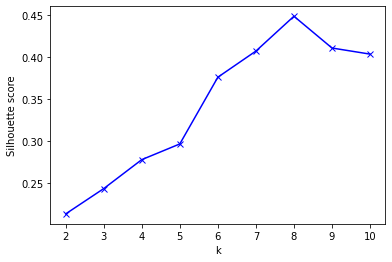

In [126]:
model = Kohonen(5,5,x,0.5)

cluster_num_seq = range(2, 11) 
silhouette_vec = count_clustering_scores(x,model, cluster_num_seq, silhouette_score, iterations=200)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

silhouette score potwierdza oryginalną liczbę klastrów (nieznacznie w stosunku do np 7 czy 9, ale jest to jednak argument dla którego silhouette score jest najwyższe)

In [11]:
measures = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }


models = {}
for width in np.linspace(1/10, 1, 10):
    width = np.round(width, 1)
    models[f'width = {width}'] = Kohonen(4,4,x,width)


df = pd.DataFrame()
for model_key in models:
    for measure_key in measures:
        df.loc[model_key, measure_key] = count_clustering_scores(X=x, cluster_num=8,
                                                                model=models[model_key],
                                                                score_fun=measures[measure_key], iterations = 500)

min dist between clusters  mean dist in clust  \
width = 0.1                   0.052589            0.856547   
width = 0.2                   0.093270            0.854540   
width = 0.3                   0.082029            0.848125   
width = 0.4                   0.093270            0.852686   
width = 0.5                   0.093270            0.858319   
width = 0.6                   0.081282            0.849424   
width = 0.7                   0.068117            0.846915   
width = 0.8                   0.080178            0.852540   
width = 0.9                   0.096924            0.850118   
width = 1.0                   0.035233            0.862558   

             mean dist to clust center  silhouette  
width = 0.1                   0.598857    0.476550  
width = 0.2                   0.601544    0.470380  
width = 0.3                   0.598220    0.472279  
width = 0.4                   0.600202    0.459240  
width = 0.5                   0.606861    0.480046  
width = 0.6                   0.597989    0.474584  
width = 0.7                   0.597806    0.469646  
width = 0.8                   0.602680    0.444823  
width = 0.9                   0.601093    0.472740  
width = 1.0                   0.597096    0.447812

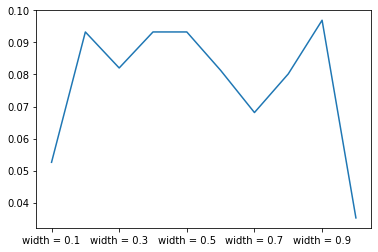

In [14]:
df['min dist between clusters'].plot()
df

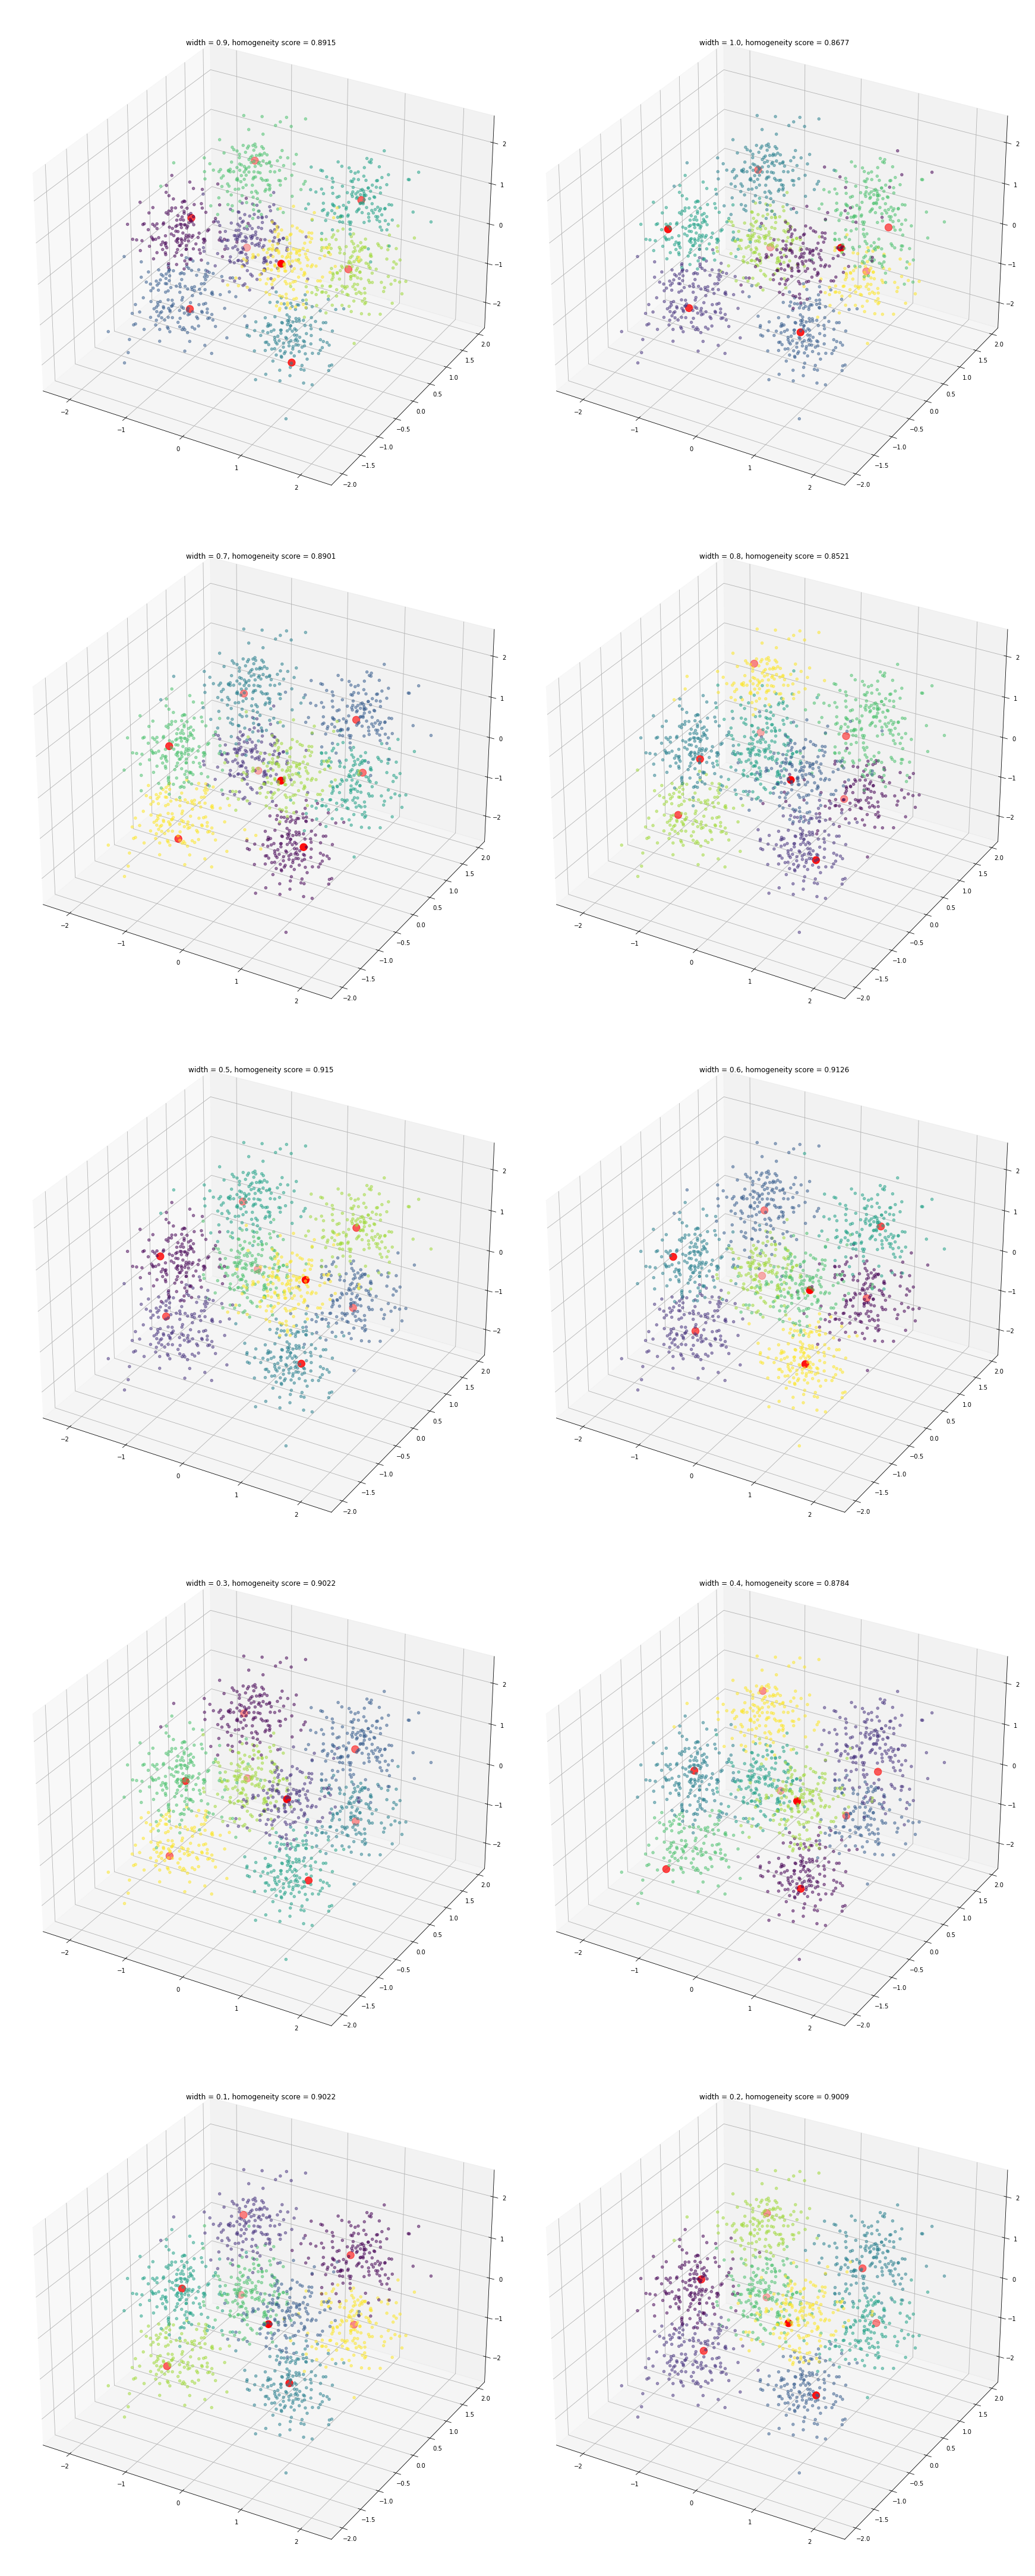

In [13]:
import seaborn as sns
fig = plt.figure(figsize=(24,24))
for i, key in enumerate(models):
    model = models[key]
    c = model.classify()
    w = 1/2
    h = 1
    a = 1/2 + (i)%2 * 1/2
    b = 1/2 * math.floor(i/2) % 5
    ax = fig.add_axes([a,b,w,h], projection='3d')
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha = 0.5)
    ax.scatter(model.neurons[:,0],model.neurons[:,1], model.neurons[:,2], color = "red", s = 150)
    ax.set_title(f"{key}, homogeneity score = {np.round(measures.homogeneity_score(labels, c), 4)}", y = 1, pad = 0)

nie ma szczególnych różnic między kolejnymi wartościami szerokości sąsiedztwa.

In [132]:
measures_1 = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
           }
measures_2 = {
    'completeness' : completeness_score,
    'homogeneity' : homogeneity_score,
    'adjusted rand score' : adjusted_rand_score,
}
models = {}
    
sizes = np.linspace(3, 13, 6)
sizes = [int(size) for size in sizes]
df = pd.DataFrame()

for size in sizes:
    model = Kohonen(size, size, x, 0.5)
    model.learn(200, 'gauss')
    model.limit_neurons(8)
    models[f'{size}x{size}'] = model
    c = model.classify()
    for measure_key in measures_1:
        fun = measures_1[measure_key]
        score = fun(x, c)
        df.loc[f'{size}x{size}', measure_key] = score

    for measure_key in measures_2:
        fun = measures_2[measure_key]
        score = fun(labels, c)
        df.loc[f'{size}x{size}', measure_key] = score
df

min dist between clusters  mean dist in clust  \
3x3                     0.153076            0.847408   
5x5                     0.055056            0.857897   
7x7                     0.085807            0.851598   
9x9                     0.103118            0.847787   
11x11                   0.117294            0.852196   
13x13                   0.159259            0.846140   

       mean dist to clust center  silhouette  completeness  homogeneity  \
3x3                     0.597767    0.478223      0.902597     0.902382   
5x5                     0.605189    0.460886      0.868722     0.864974   
7x7                     0.600214    0.468823      0.890446     0.888086   
9x9                     0.598017    0.477794      0.904816     0.904546   
11x11                   0.601649    0.470648      0.900029     0.897876   
13x13                   0.596937    0.478302      0.913992     0.913320   

       adjusted rand score  
3x3               0.895677  
5x5               0.828065  
7x7               0.864933  
9x9               0.899492  
11x11             0.879224  
13x13             0.904641

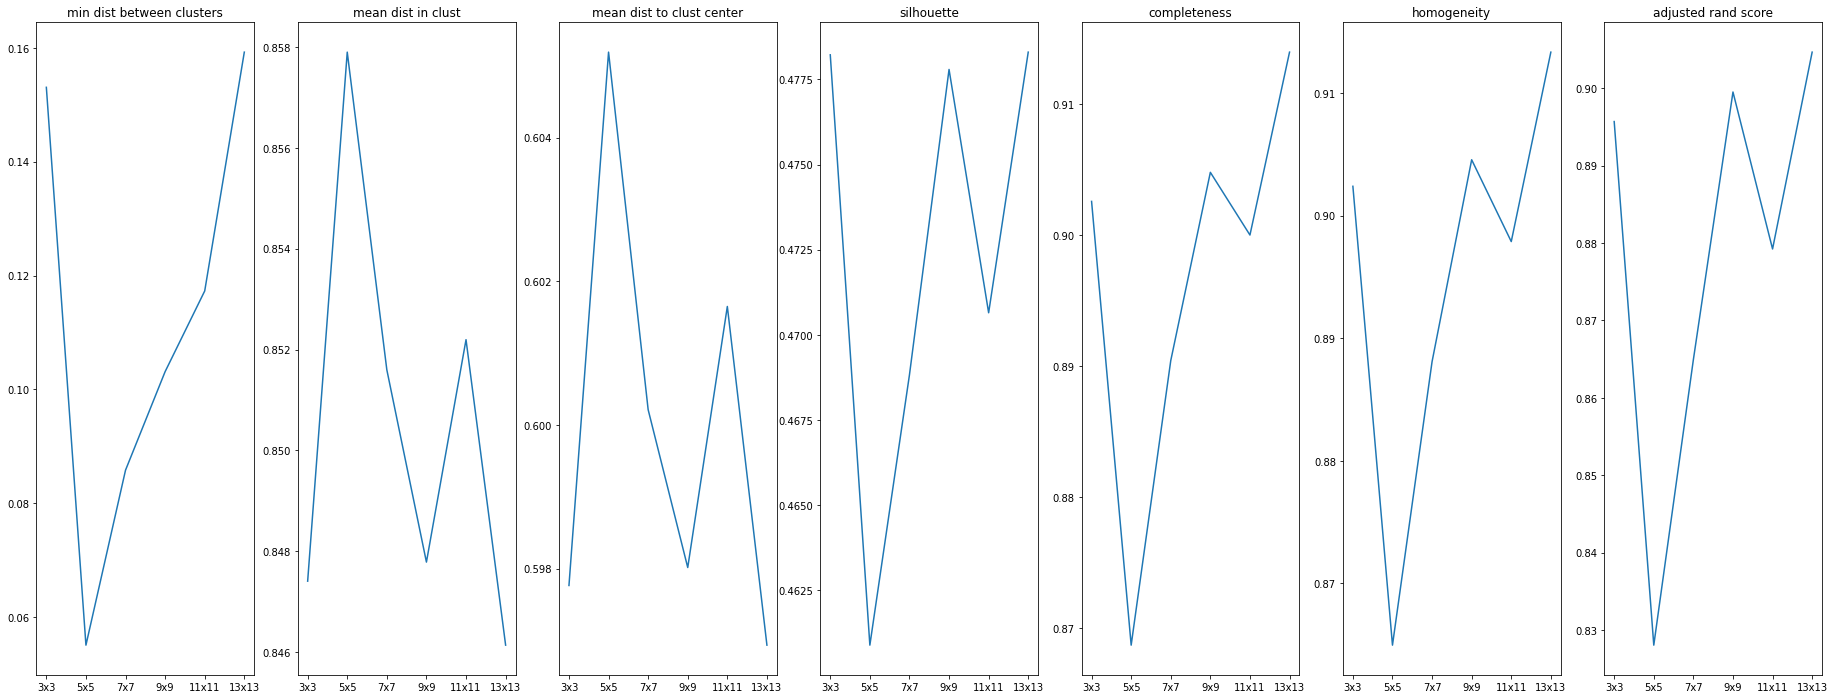

In [135]:
plt.figure(figsize = (32,12))
i = 1
for key in measures_1:
    plt.subplot(1,7,i)
    df[key].plot()
    plt.title(key)
    i+=1
for key in measures_2:
    plt.subplot(1,7,i)
    df[key].plot()
    plt.title(key)
    i+=1

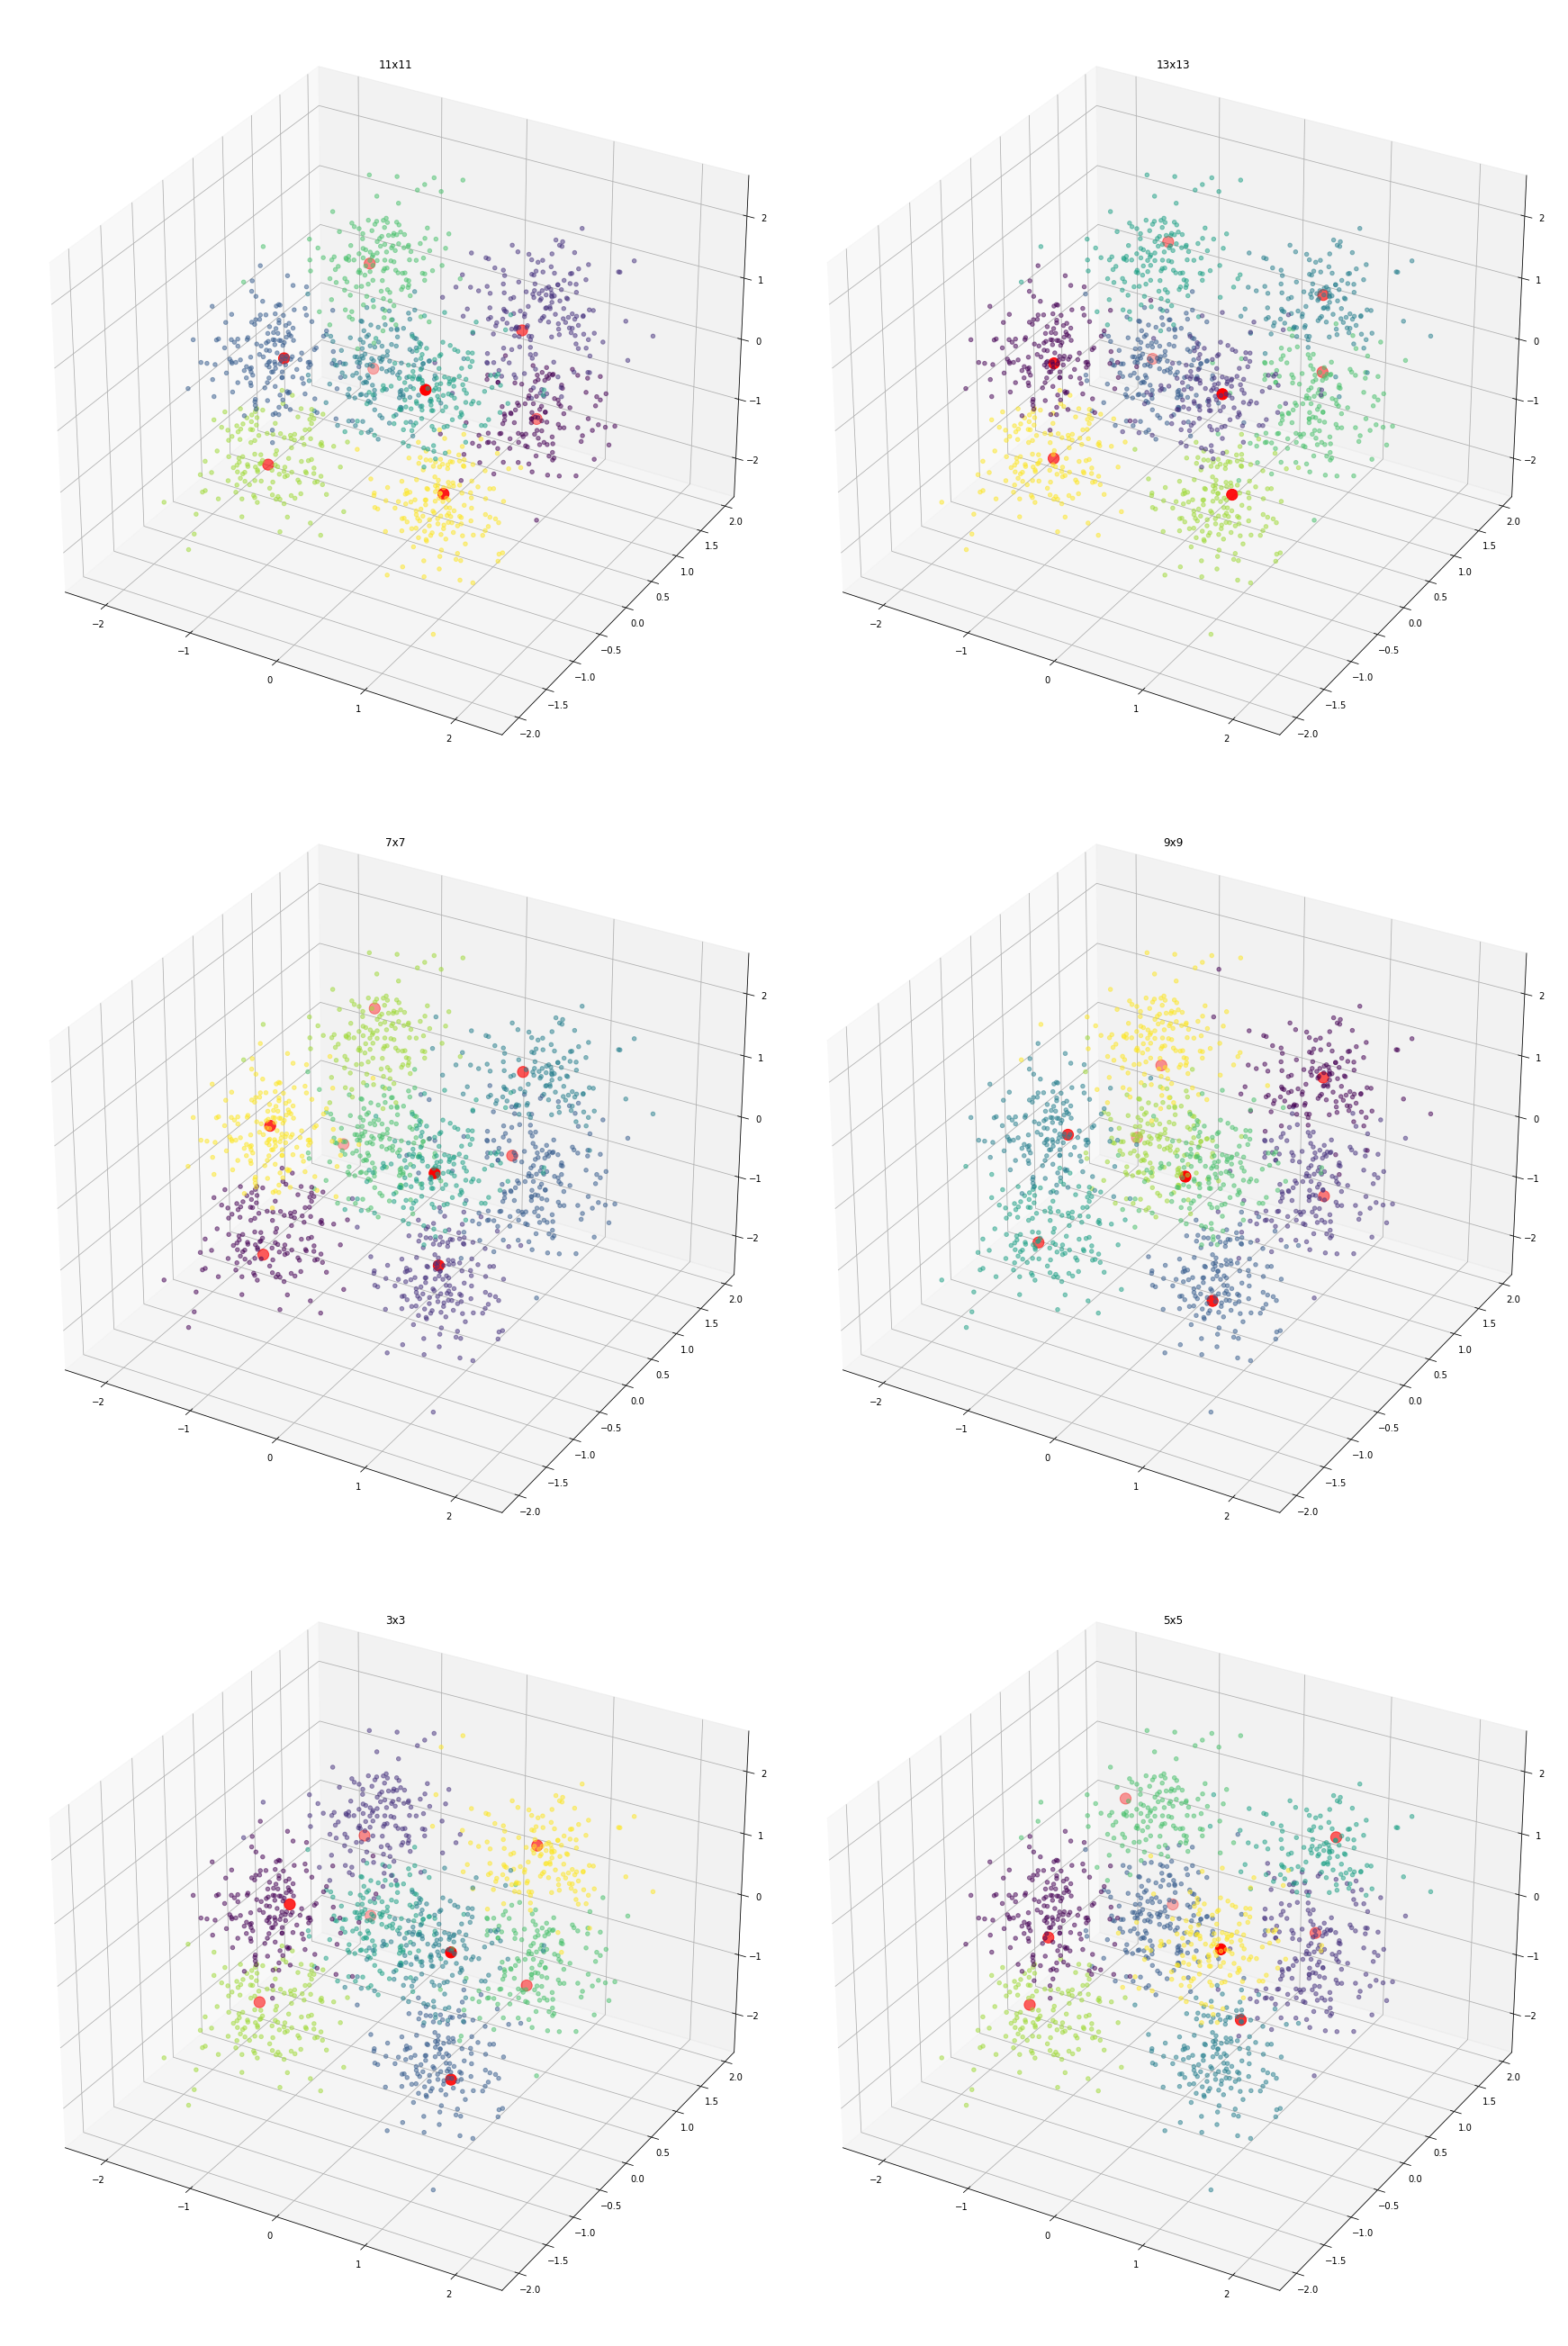

In [143]:
fig = plt.figure(figsize=(24,24))
for i, model_key in enumerate(models):
    model =  models[model_key]
    c = model.classify()
    w = 1/2
    h = 1
    a = 1/2 + (i)%2 * 1/2
    b = 1/2 * math.floor(i/2) % 5
    ax = fig.add_axes([a,b,w,h], projection = '3d')
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha = 0.5)
    ax.scatter(model.neurons[:,0],model.neurons[:,1], model.neurons[:,2], color = "red", s = 150)
    ax.set_title(model_key, y = 1, pad = 0)

### kapelusz meksykański jako funkcja sąsiedztwa

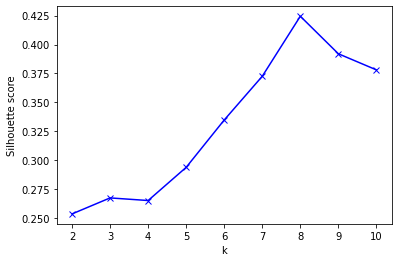

In [15]:
model = Kohonen(4,4,x,1)

cluster_num_seq = range(2, 11) 
silhouette_vec = count_clustering_scores(x,model, cluster_num_seq, silhouette_score, iterations=500, method='mexican')
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wykres wartości silhouette posiada ewidentny szczyt dla 8 klastrów

In [16]:
measures = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }


models = {}
for width in np.linspace(1/10, 1, 10):
    width = np.round(width, 1)
    models[f'width = {width}'] = Kohonen(4,4,x,width)


df = pd.DataFrame()
for model_key in models:
    for measure_key in measures:
        df.loc[model_key, measure_key] = count_clustering_scores(X=x, cluster_num=8,
                                                                model=models[model_key],
                                                                score_fun=measures[measure_key], iterations = 500, method = 'mexican')

min dist between clusters  mean dist in clust  \
width = 0.1                   0.071119            0.851343   
width = 0.2                   0.111860            0.851548   
width = 0.3                   0.082029            0.848177   
width = 0.4                   0.082029            0.896163   
width = 0.5                   0.103118            0.852389   
width = 0.6                   0.047695            0.852518   
width = 0.7                   0.066884            0.852038   
width = 0.8                   0.060737            0.848885   
width = 0.9                   0.077468            0.852129   
width = 1.0                   0.081513            0.860317   

             mean dist to clust center  silhouette  
width = 0.1                   0.596663    0.475869  
width = 0.2                   0.602350    0.456263  
width = 0.3                   0.603821    0.388892  
width = 0.4                   0.600631    0.473625  
width = 0.5                   0.603170    0.449081  
width = 0.6                   0.598303    0.432927  
width = 0.7                   0.602294    0.467843  
width = 0.8                   0.597054    0.477469  
width = 0.9                   0.607966    0.477489  
width = 1.0                   0.603244    0.470196

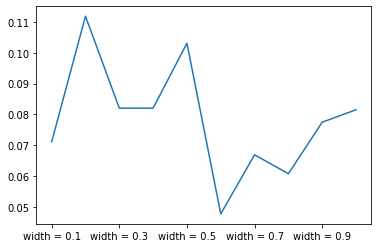

In [17]:
df['min dist between clusters'].plot()
df

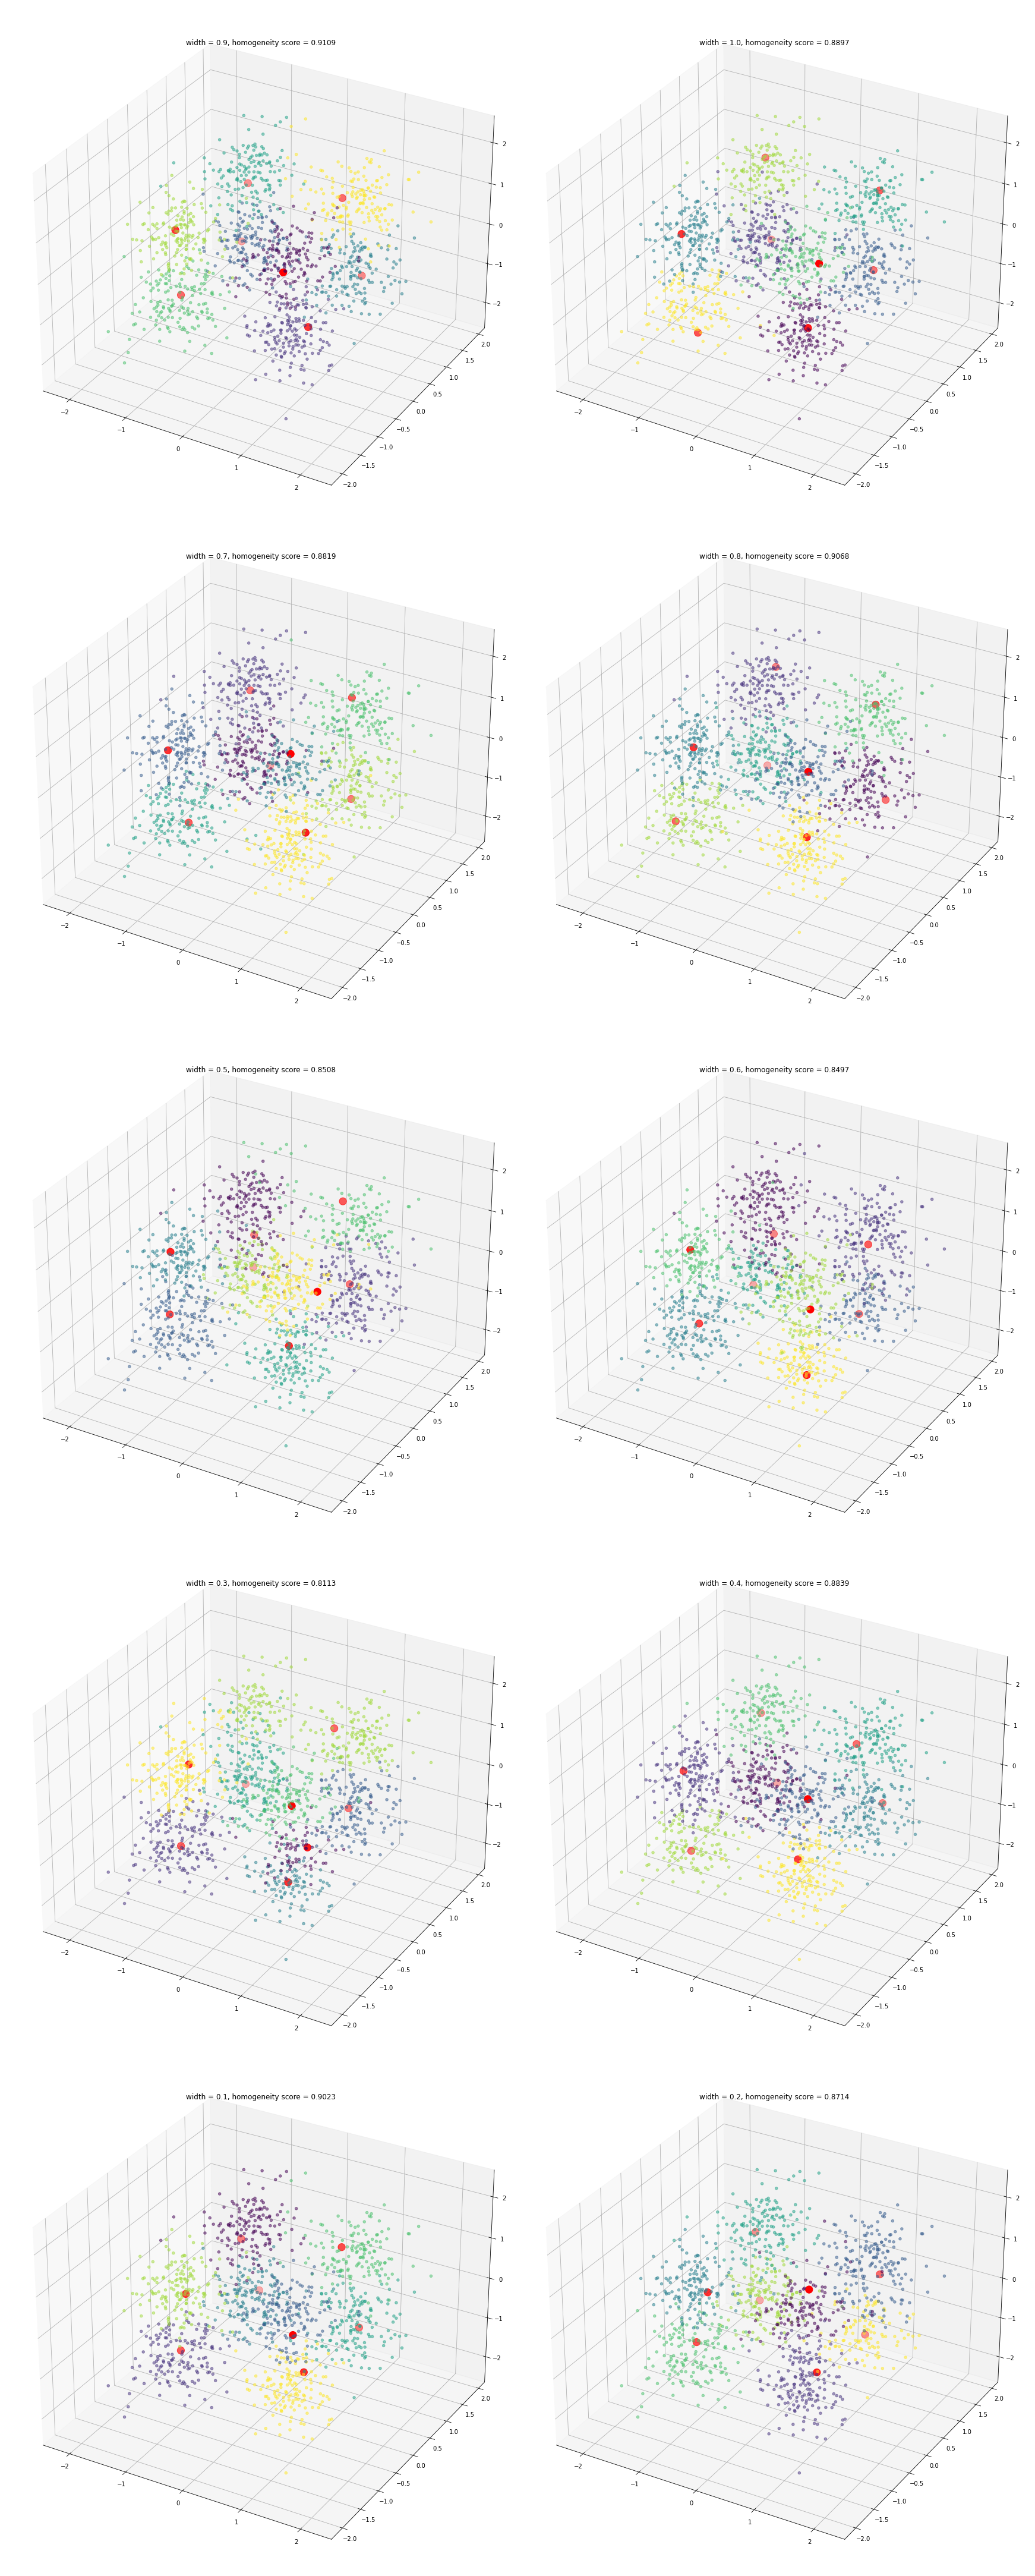

In [18]:
import seaborn as sns
fig = plt.figure(figsize=(24,24))
for i, key in enumerate(models):
    model = models[key]
    c = model.classify()
    w = 1/2
    h = 1
    a = 1/2 + (i)%2 * 1/2
    b = 1/2 * math.floor(i/2) % 5
    ax = fig.add_axes([a,b,w,h], projection='3d')
    ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, alpha = 0.5)
    ax.scatter(model.neurons[:,0],model.neurons[:,1], model.neurons[:,2], color = "red", s = 150)
    ax.set_title(f"{key}, homogeneity score = {np.round(measures.homogeneity_score(labels, c), 4)}", y = 1, pad = 0)

ciekawy przypadek dla width = 0.3, zainicjowane wagi wypadły w taki sposób, że algorytm nie odnalazł wszystkich 8 wierzchołków sześcianu

In [144]:
measures_1 = {
            'min dist between clusters': min_dist_between_clusters,
            'mean dist in clust': mean_dist_in_clusters,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
           }
measures_2 = {
    'completeness' : completeness_score,
    'homogeneity' : homogeneity_score,
    'adjusted rand score' : adjusted_rand_score,
}
models = {}
    
sizes = np.linspace(3, 13, 6)
sizes = [int(size) for size in sizes]
df = pd.DataFrame()

for size in sizes:
    model = Kohonen(size, size, x, 0.1)
    model.learn(200, 'mexican')
    model.limit_neurons(8)
    c = model.classify()
    for measure_key in measures_1:
        fun = measures_1[measure_key]
        score = fun(x, c)
        df.loc[f'{size}x{size}', measure_key] = score

    for measure_key in measures_2:
        fun = measures_2[measure_key]
        score = fun(labels, c)
        df.loc[f'{size}x{size}', measure_key] = score
df

min dist between clusters  mean dist in clust  \
3x3                     0.097365            0.849292   
5x5                     0.125823            0.850161   
7x7                     0.085807            0.851328   
9x9                     0.116595            0.851266   
11x11                   0.103118            0.847734   
13x13                   0.093737            0.854707   

       mean dist to clust center  silhouette  completeness  homogeneity  \
3x3                     0.599115    0.472980      0.892269     0.891434   
5x5                     0.599483    0.472169      0.896867     0.895307   
7x7                     0.600356    0.471407      0.900694     0.899466   
9x9                     0.599894    0.473005      0.892205     0.891119   
11x11                   0.597725    0.476888      0.906691     0.906052   
13x13                   0.603372    0.466475      0.895802     0.892667   

       adjusted rand score  
3x3               0.873785  
5x5               0.875758  
7x7               0.886488  
9x9               0.873259  
11x11             0.897064  
13x13             0.868717

## wnioski

obie funkcje sąsiedztwa sprawdziły się podobnie.  
W przypadku drugiego zbioru danych funkcja sąsiedztwa określona jako minus druga pochodna funkcji gaussowskiej umożliwiła łatwiejsze odczytanie liczby klastrów.  
Z doświadczeń przeprowadzonych w trakcie rozwijania tego raportu wnioskuję, że funkcja gaussowska jest bardziej stabilna numerycznie niż jej druga pochodna(bywały problemy z eksplozją wag do +/- nieskończoności).  

odpowiedzi na pytania:
- _Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych?_  
Tak, algorytm w każdym przypadku poprawnie zidentyfikował liczbę klastrów, co zweryfikowałem przy pomocy wykresu wartości _Silhouette Score_.
- _Czy znalezione klastry pokrywają się z identyfikatorami wierzchołków?_
Tak, 